<a href="https://colab.research.google.com/github/AlyAbdulloh/Machine-Learning-semester5/blob/main/JS10/JS10(RNN)_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum 2

**Generator Teks dengan RNN**

In [1]:
import tensorflow as tf
import numpy as np
import os
import time

## Setup

**Download Dataset Shakespeare**

In [3]:
path_to_file = tf.keras.utils.get_file('/content/data/shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 1s 1us/step


**Load Data**

In [4]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [5]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [6]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


## Olah Teks

**Vectorize Teks**

Sebelum training, Anda perlu mengonversi string menjadi representasi numerik. `tf.keras.layers.StringLookup` dapat mengubah setiap karakter menjadi ID numerik. Caranya adalah teks akan dipecah menjadi token terlebih dahulu.

In [7]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

sekarang buat tf.keras.layers.StringLookup layer:

In [8]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

perintah diatas mengconvert token menjadi id

In [9]:
ids = ids_from_chars(chars)
ids


<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Karena tujuan tutorial ini adalah untuk menghasilkan teks, penting juga untuk membalikkan representasi ini. Untuk ini Anda dapat menggunakan kode `tf.keras.layers.StringLookup(..., invert=True)`.

Catatan: pada kode ini, daripada meneruskan kosakata asli yang dihasilkan dengan diurutkan(set(teks)) gunakan metode `get_vocabulary()` dari `tf.keras.layers.StringLookup` sehingga token [UNK] disetel dengan cara yang sama.

In [10]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

Lapisan ini mengconvert kembali karakter dari vektor ID, dan mengembalikannya sebagai karakter `tf.RaggedTensor`:

In [12]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Anda dapat menggunakan `tf.strings.reduce_join` untuk menggabungkan kembali karakter menjadi string.

In [13]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [14]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

**Prediksi**

Diberikan sebuah karakter, atau serangkaian karakter, karakter apa yang paling mungkin berikutnya? Ini adalah tugas yang harus Anda latih agar model dapat melakukannya. Masukan ke model akan berupa urutan karakter, dan Anda melatih model untuk memprediksi keluaran berupa karakter berikut pada setiap langkah waktu. Karena RNN mempertahankan keadaan internal yang bergantung pada elemen yang terlihat sebelumnya, mengingat semua karakter dihitung hingga saat ini, karakter apa selanjutnya?

**Membuat Trianing Set dan Target**

Selanjutnya bagilah teks menjadi contoh sequence. Setiap masukan sequence akan berisi karakter seq_length dari teks. Untuk setiap masukan sequence, target prediksi berisi teks dengan panjang yang sama, hanya digeser satu karakter ke kanan. Jadi, bagi teks menjadi beberapa bagian seq_length+1. Misalnya, seq_length adalah 4 dan teks kita adalah "Hello". Urutan masukannya adalah "Hell", dan urutan targetnya adalah "ello". Untuk melakukan ini, pertama-tama gunakan fungsi tf.data.Dataset.from_tensor_slices untuk mengonversi vektor teks menjadi aliran indeks karakter.

In [15]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [16]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [17]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [18]:
seq_length = 100

Metode batch memungkinkan Anda dengan mudah mengonversi karakter individual ini menjadi urutan ukuran yang diinginkan.

In [20]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


akan lebih mudah untuk melihat apa yang dilakukan jika Anda menggabungkan token kembali menjadi string:

In [21]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


Untuk pelatihan, Anda memerlukan kumpulan data pasangan (input, label). Dimana input dan label merupakan urutan. Pada setiap langkah waktu, inputnya adalah karakter saat ini dan labelnya adalah karakter berikutnya. Berikut adalah fungsi yang mengambil urutan sebagai masukan, menduplikasi, dan menggesernya untuk menyelaraskan masukan dan label untuk setiap langkah waktu:

In [22]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [23]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [24]:
dataset = sequences.map(split_input_target)

In [25]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


**Membuat Batch Training**

Anda menggunakan tf.data untuk membagi teks menjadi sequence yang dapat diatur. Namun sebelum memasukkan data ini ke dalam model, Anda perlu mengacak data dan mengemasnya ke dalam batch.

In [26]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

## Buat Model

In [27]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [28]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [29]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

## Uji Model

Coba jalankan model dan cek apakah sidah sesuai dengan output

pertama, cek bentuk dari output

In [30]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


Dalam contoh di atas, panjang urutan masukan adalah 100 tetapi model dapat dijalankan pada masukan dengan panjang berapa pun:

In [31]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Untuk mendapatkan prediksi aktual dari model, Anda perlu mengambil sampel dari distribusi keluaran, untuk mendapatkan indeks karakter aktual. Distribusi ini ditentukan oleh logit pada kosakata karakter. Catatan: Penting untuk mengambil sampel dari distribusi ini karena mengambil argmax dari distribusi tersebut dapat dengan mudah membuat model terjebak dalam infinote loop. Cobalah untuk contoh pertama di batch:

In [32]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

Hal ini memberi kita, pada setiap langkah waktu, prediksi indeks karakter berikutnya:

In [33]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'espected\nwith man, woman, or child.\n\nPOMPEY:\nSir, she was respected with him before he married with '

Next Char Predictions:
 b"$![UNK]uP-oRS3KKxO WBaLEk,uJS'X uW:Mc!'P[UNK]Bt[UNK]&z'\nFegHCJEq?y:YEnm?Yb;Owrf$WfH.FnlwiznREboX.z;d hytC$?K3Rjs"


## Train Model

Pada titik ini permasalahan dapat dianggap sebagai permasalahan klasifikasi standar. Permasalahan dapat disimpulkan dengan : Berdasarkan status RNN sebelumnya, dan masukan langkah kali ini, prediksi kelas karakter berikutnya.

**Tambahan optimizer dan fungsi loss**

loss function `tf.keras.losses.sparse_categorical_crossentropy` standar berfungsi dalam kasus ini karena diterapkan di seluruh dimensi terakhir prediksi. Karena model Anda mengembalikan logits, Anda perlu mengatur flag `from_logits`.

In [34]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [35]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.18796, shape=(), dtype=float32)


Model yang baru diinisialisasi tidak boleh terlalu yakin dengan dirinya sendiri, semua log keluaran harus memiliki besaran yang sama. Untuk mengonfirmasi hal ini, Anda dapat memeriksa bahwa eksponensial dari loss rata-rata harus kira-kira sama dengan ukuran kosakata. Loss yang jauh lebih tinggi berarti model tersebut yakin akan jawaban yang salah, dan memiliki inisialisasi yang buruk:

In [36]:
tf.exp(example_batch_mean_loss).numpy()

65.88825

Konfigurasikan prosedur pelatihan menggunakan metode tf.keras.Model.compile. Gunakan tf.keras.optimizers.Adam dengan argumen default dan fungsi loss.

In [37]:
model.compile(optimizer='adam', loss=loss)

**Konfigurasi Checkpoints**

Gunakan `tf.keras.callbacks.ModelCheckpoint` untuk memastikan bahwa checkpoint disimpan selama pelatihan:

In [38]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

**Lakukan Proses Training**

Agar waktu pelatihan tidak terlalu lama, gunakan 10 epoch untuk melatih model. Di Colab, setel runtime ke GPU untuk pelatihan yang lebih cepat.

In [39]:
EPOCHS = 20

In [40]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 16s 60ms/step - loss: 2.6904
Epoch 2/20
172/172 [==============================] - 12s 57ms/step - loss: 1.9696
Epoch 3/20
172/172 [==============================] - 11s 56ms/step - loss: 1.6902
Epoch 4/20
172/172 [==============================] - 11s 56ms/step - loss: 1.5320
Epoch 5/20
172/172 [==============================] - 12s 57ms/step - loss: 1.4364
Epoch 6/20
172/172 [==============================] - 12s 57ms/step - loss: 1.3713
Epoch 7/20
172/172 [==============================] - 11s 56ms/step - loss: 1.3185
Epoch 8/20
172/172 [==============================] - 11s 56ms/step - loss: 1.2751
Epoch 9/20
172/172 [==============================] - 12s 57ms/step - loss: 1.2332
Epoch 10/20
172/172 [==============================] - 12s 57ms/step - loss: 1.1931
Epoch 11/20
172/172 [==============================] - 12s 57ms/step - loss: 1.1529
Epoch 12/20
172/172 [==============================] - 12s 57ms/step - loss: 1.1109
E

## Generate Teks

Cara termudah untuk menghasilkan teks dengan model ini adalah dengan menjalankannya dalam loop, dan menyimpan status internal model saat Anda menjalankannya.

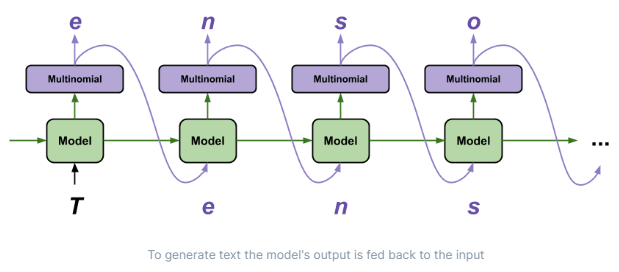

Setiap kali Anda memanggil model, Anda memasukkan beberapa teks dan state internal. Model mengembalikan prediksi untuk karakter berikutnya dan state barunya. Masukkan kembali prediksi dan state ke model untuk terus menghasilkan teks.

Berikut ini membuat prediksi satu langkah:

In [41]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [42]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Jalankan secara berulang untuk menghasilkan beberapa teks. Melihat teks yang dihasilkan, Anda akan melihat model mengetahui kapan harus menggunakan huruf besar, membuat paragraf, dan meniru kosakata menulis seperti Shakespeare. Karena sedikitnya jumlah epoch pelatihan, model belum belajar membentuk kalimat runtut.

In [43]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
I care not.

TRANIO:
Faith, no whose names a dam?--my rape,
May trust it o'er-she came into a sight.

DUKE OF YORK:
You bid me good on ear. This is a king,
Nor to my heart, thousand noses and his own care as this hour,
Your uncle York us pursued, she is willing.
I meetent with briad justice: but he's more
visage that was much unkindness, for they troable
Miles, yields their hearts! Dost noble will!

ISABELLA:
Who cast offends them love?

Nurse:
His nurse! how blood, take up my heart or naw?
O thou three earth, I will push thee everlashing
He hath still my horse and unfewler hearts;
And, he enjost the people had rone's ease.
Awaked him to the Dorset, and is no less spread fall
The anger wholes me over eight to fly,
To brief thine crap'd not with your exile;
That brought to thee profane that rogue.

Shepherd:
Why, there's no man ever have to sceptor' death:
Signio Be pattife, I would have happy heart.
The dirn to him, who begin his winters, heart
shall not me but something that I 

Hal termudah yang dapat Anda lakukan untuk meningkatkan hasil adalah dengan melatihnya lebih lama (coba EPOCHS = 30). Anda juga dapat bereksperimen dengan string awal yang berbeda, mencoba menambahkan lapisan RNN lain untuk meningkatkan akurasi model, atau menyesuaikan parameter suhu untuk menghasilkan prediksi yang kurang lebih acak.

Jika Anda ingin model menghasilkan teks lebih cepat, hal termudah yang dapat Anda lakukan adalah membuat teks secara batch. Pada contoh di bawah, model menghasilkan 5 keluaran dalam waktu yang hampir sama dengan waktu yang dibutuhkan untuk menghasilkan 1 keluaran di atas.

In [44]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nThat would how could he love me rid thyself;\nYou quickly soon as and wrong'd by,\nHis name is Lucentio; and thou, he, conspired\nAttorney'd by his hands and heirs,\nThy body in full, that he will not,\nWell demanded what you have so, I am additted\nbefore the Duke of Gloucester!\nThis do it far false droost, and here we lawful king;\nTake title she was not wander'd in thy sleep'st,\nWithout poor Richard, cousin AAgedon pend;\nBut imagine honest with you as free,\nAs is the kind of comfort back: when most I pray,\nAs I came well to her once, for our father's death?\n\nDAKE OF YORK:\nNo; but there's a man that is not hurl.\n\nShepherd:\nI know not what, by God's health!\nAnd leivers to Romeo, the ship, sir.\n\nSICINIUS:\nHear us,\nOrbeldom, abouh so, To hate, and thou\nShalt fail out-fashion! where the duke hath spoke his\nman, sir, how he's\nProclaim 'tis all under whilst o' his\nbehalf as he makes; even to attendent him;\nI have stricted than any man that's flesh

## Ekspor Model Generator

Model satu langkah ini dapat dengan mudah disimpan dan digunakan kembali, memungkinkan Anda menggunakannya di mana pun `tf.saved_model` diterima.

In [45]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [46]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
O'er life, seek hand, I know it; we'll have no cause to go
the plate; and, take a happy day, posses
